QAOA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [2]:
np.random.seed(100)

In [3]:
# Create random Q matrix with 5 variables and constant diagonal of 10.
random_matrix = np.random.uniform(0, 20, (5, 5))
Q = (random_matrix + random_matrix.T) /2
np.fill_diagonal(Q, -10.0)
print(Q)

[[-10.           3.99938506  13.15839545  18.23399917   4.3642304 ]
 [  3.99938506 -10.          10.35054877   9.48389739  15.15123149]
 [ 13.15839545  10.35054877 -10.           2.80317903  10.37346871]
 [ 18.23399917   9.48389739   2.80317903 -10.           6.10185697]
 [  4.3642304   15.15123149  10.37346871   6.10185697 -10.        ]]


#### Brute Force Approach

In [4]:
# Classical approximation
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]

costs = []
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)

zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])
indexes = [i[0] for i in sort_zipped[:3]]
print(indexes)

[('00110', -14.393641936063013), ('11000', -12.001229882461793), ('10001', -11.271539202918113)]
['00110', '11000', '10001']


### Mapping QUBO to NAQC

We now illustrate how to use Pulser to embbed the QUBO matrix ${Q}$ on a neutral-atom device.

The key idea is to encode the off-diagonal terms of ${Q}$ by using the Rydberg interaction between atoms. Recalling that the interaction between two atoms is given by:

$$U_{ij}=C_6/r_{ij}^6,$$

we note that

- The term is strictly positive, which is why it matters that our off-diagonal terms are too.
- Its magnitude depends on the pairwise distance between atoms $i$ and $j$, $r_{ij}$.

As such, we attempt a simple minimization procedure to find the optimal positions of the atoms in the Register that replicate best the off-diagonal terms of $Q$:

In [5]:
# Maps the QUBO to Rydberg Atoms in NAQC
# Calculates the distances between atoms on the hardware and those in the Q matrix.
def mapping(coords, Q):
    coords = np.reshape(coords, (len(Q), 2))
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [6]:
# Perform optimization
# Create random initial coordinates
x0 = np.random.random(len(Q)*2)

# Optimize atom coordinates.
optimal_pos = minimize(
    mapping, 
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 20000, "maxfev": None}
)

# Reshape coordinates
coords = np.reshape(optimal_pos.x, (len(Q), 2))
print(coords)

[[-7.58067243  0.33432527]
 [ 0.95975567  6.38543276]
 [ 0.52863421 -2.59027552]
 [16.88442436 -2.33890851]
 [ 8.18610915  2.06715561]]


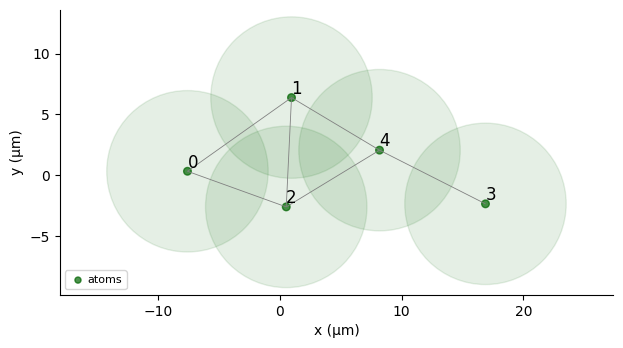

In [7]:
# Create a Register
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius = DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

### Construct QAOA Layers

In [8]:
# Number of layers
layers = 2
omega = 2 * np.pi
detuning = 10

# Define sequence with two pulses
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

# Define variables for sequence of pulses
t_list = seq.declare_variable("t_list", size=layers) 
s_list = seq.declare_variable("s_list", size=layers)

for t, s in zip(t_list, s_list):
    pulse1 = Pulse.ConstantPulse(200 * t, omega, 0.0, 0) # omega - transverse field term
    pulse2 = Pulse.ConstantPulse(200 * s, 0.0, detuning, 0) # detuning - sigmaz term

    seq.add(pulse1, "ch0")
    seq.add(pulse2, "ch0")

seq.measure("ground-rydberg")

In [9]:
# Define the pulse params
param_dict = {
    "t": np.random.uniform(8, 10, layers), # min,max and size
    "s": np.random.uniform(1, 3, layers),
} 

In [12]:
params = np.array()
t_params, s_params = np.reshape(params.astype(int), (2, layers))

sample_sequence = seq.build(t_list=t_params, s_list=s_params)

TypeError: array() missing required argument 'object' (pos 0)

In [13]:
# Define a quantum loop that runs these sequences
def quantum_loop(params):
    params = np.array(params)
    t_params, s_params = np.reshape(params.astype(int), (2, layers))

    sample_sequence = seq.build(t_list=t_params, s_list=s_params)
    simulate = QutipEmulator.from_sequence(sample_sequence, sampling_rate=0.01) #
    results = simulate.run()

    count_dict = results.sample_final_state(N_samples = 100)
    return count_dict

Perform a sample run

In [14]:
# Sample run (single layer of QAOA)
sample_run = quantum_loop(np.r_[param_dict["t"], param_dict["s"]])
print(sample_run)

Counter({'00001': 14, '00010': 9, '10001': 9, '00100': 8, '01100': 8, '01000': 7, '11010': 7, '00000': 5, '11100': 5, '01110': 4, '10110': 4, '00011': 3, '01010': 3, '10100': 3, '11011': 3, '00111': 2, '01011': 2, '00110': 1, '10000': 1, '11000': 1, '11001': 1})


c:\Users\navan\anaconda3\envs\qc\lib\site-packages\pulser\parametrized\paramobj.py:198: UserWarning: A waveform duration of array(1956.16462538) ns is below the supported precision of 1 ns. It was rounded down to 1956 ns.
  self._instance = obj(*args_, **kwargs_)
c:\Users\navan\anaconda3\envs\qc\lib\site-packages\pulser\parametrized\paramobj.py:198: UserWarning: A waveform duration of array(223.97679553) ns is below the supported precision of 1 ns. It was rounded down to 223 ns.
  self._instance = obj(*args_, **kwargs_)
c:\Users\navan\anaconda3\envs\qc\lib\site-packages\pulser\sequence\sequence.py:1282: UserWarning: A duration of 223 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 224 ns.
  self._add(pulse, channel, protocol)
c:\Users\navan\anaconda3\envs\qc\lib\site-packages\pulser\parametrized\paramobj.py:198: UserWarning: A waveform duration of array(1992.3683428) ns is below the supported precision of 1 ns. It was rounded down to 1992 ns.
  self._ins

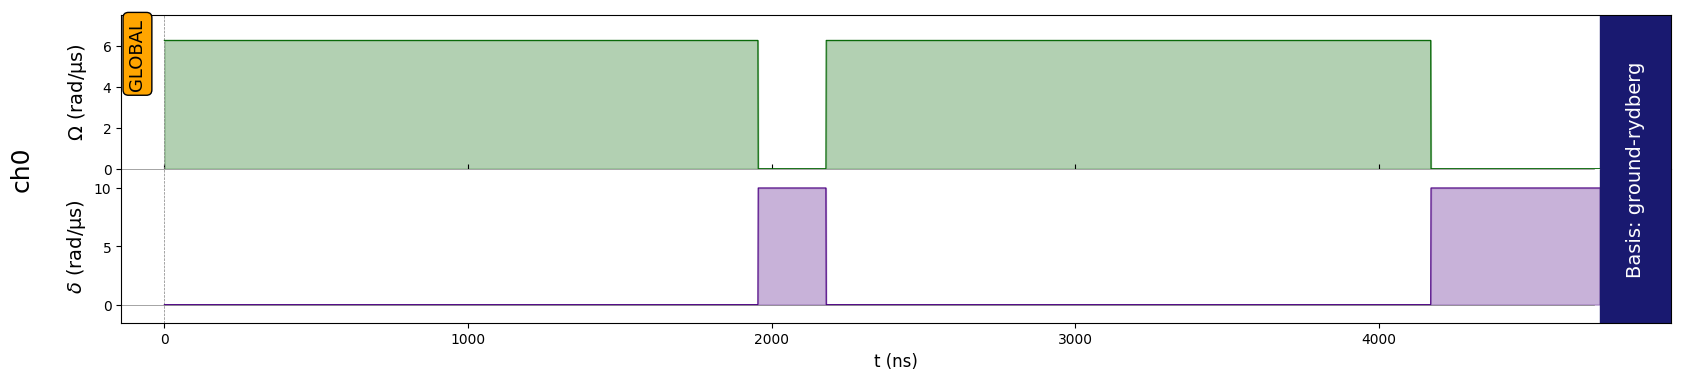

In [15]:
# Draw sequence
sample_sequence = seq.build(t_list=param_dict["t"], s_list=param_dict["s"])
sample_sequence.draw()

All atoms are initially in the groundstate $|00\cdots 0\rangle$ 
 of the `ground-rydberg` basis. We then apply `p`
 layers of alternating non-commutative Hamiltonians. The first one, called the mixing Hamiltonian $H_{M}$
, is realized by taking 
 $\Omega = 1$ rad/µs, and $\delta = 0$ 
 rad/µs in the Hamiltonian equation. The second Hamiltonian $H_{Q}$
 is realized with 
 $\Omega=0$ rad/µs and 
 $\delta=1$ rad/µs. $H_M$
 and $H_Q$
 are applied turn in turn with parameters $t$
 and $s$
 respectively. A classical optimizer is then used to estimate the optimal parameters.

 The above example is using a sample sequence, random guess for $t$ and $s$ value.

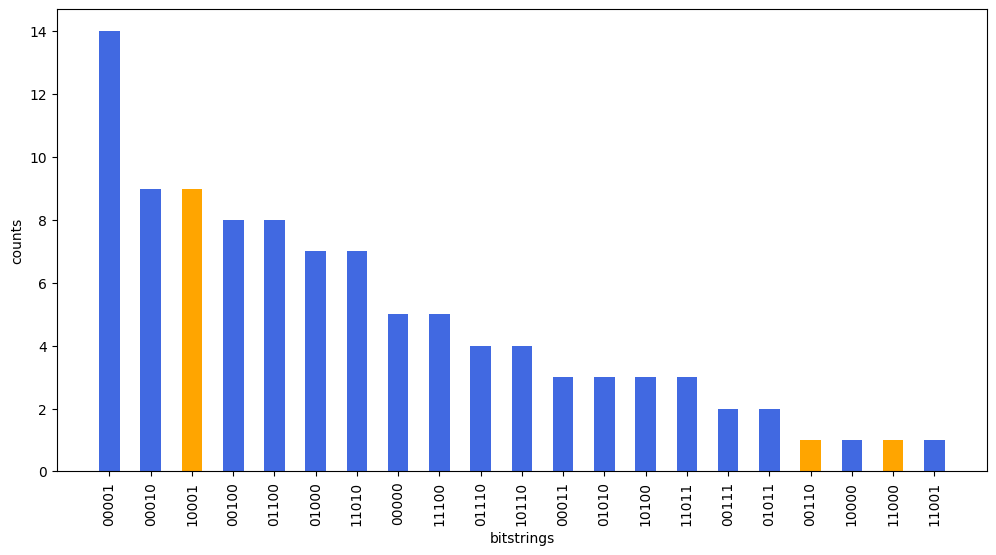

In [16]:
# Plot distribution
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "orange" if key in indexes else "royalblue" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

plot_distribution(sample_run)

### Build the QAOA - Defining important functions

Now we are going to treat $t$ and $s$ as parameters. When we are trying to solve the maxcut, at hardware level we are mapping it as optimizing the pulse sequence (duration).

In [17]:
# Get cost based on Q matix
def get_cost_Q(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

In [18]:
# Get avergae cost
def get_avg_cost(counter, Q):
    cost = sum(counter[key] * get_cost_Q(key, Q) for key in counter)
    return cost / sum(counter.values())

In [19]:
# Main function that runs the pulses, obtains samples, and calcualtes the avg cost
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_avg_cost(C, Q)
    return cost

Optimization Loop for QAOA with depth of 2 layers

In [29]:
# Optimization loop for QAOA (Main)
scores = []
params = []
for repetition in range(20):
    param_dict = {
        "t": np.random.uniform(8, 10, layers), #uniform distribution in low=8 and high=10, size=layers
        "s": np.random.uniform(1, 3, layers),
    }
    iteration = 0
    def callback(xk):
        global iteration
        print(f"trail-{repetition} Iteration {iteration}: x = {xk}")
        iteration += 1

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[param_dict["t"], param_dict["s"]],
            method="COBYLA",
            tol=1e-5,
            options={'maxiter':10}, callback=callback,
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

trail-0 Iteration 0: x = [10.39049981  8.4283701   2.74532716  2.79378872]
trail-0 Iteration 1: x = [10.39049981  9.4283701   2.74532716  2.79378872]
trail-0 Iteration 2: x = [10.39049981  9.4283701   3.74532716  2.79378872]
trail-0 Iteration 3: x = [10.39049981  9.4283701   3.74532716  3.79378872]
trail-0 Iteration 4: x = [10.68063259 10.11691926  4.34419948  4.082016  ]
trail-0 Iteration 5: x = [9.89855976 9.49270373 3.80128196 3.82071884]
trail-0 Iteration 6: x = [10.39049981  9.26430453  3.93396037  3.79378872]
trail-0 Iteration 7: x = [10.47728873  9.64136245  3.30304599  3.83238029]
trail-0 Iteration 8: x = [10.45601383  9.21111093  3.8461127   3.8229202 ]
trail-0 Iteration 9: x = [10.37651856  9.39518951  3.71646802  3.67761763]
trail-0 Iteration 10: x = [10.39049981  9.4283701   3.74532716  3.79378872]
trail-1 Iteration 0: x = [9.08553471 8.23897075 1.89997906 1.11284758]
trail-1 Iteration 1: x = [8.08553471 9.23897075 1.89997906 1.11284758]
trail-1 Iteration 2: x = [8.08553471

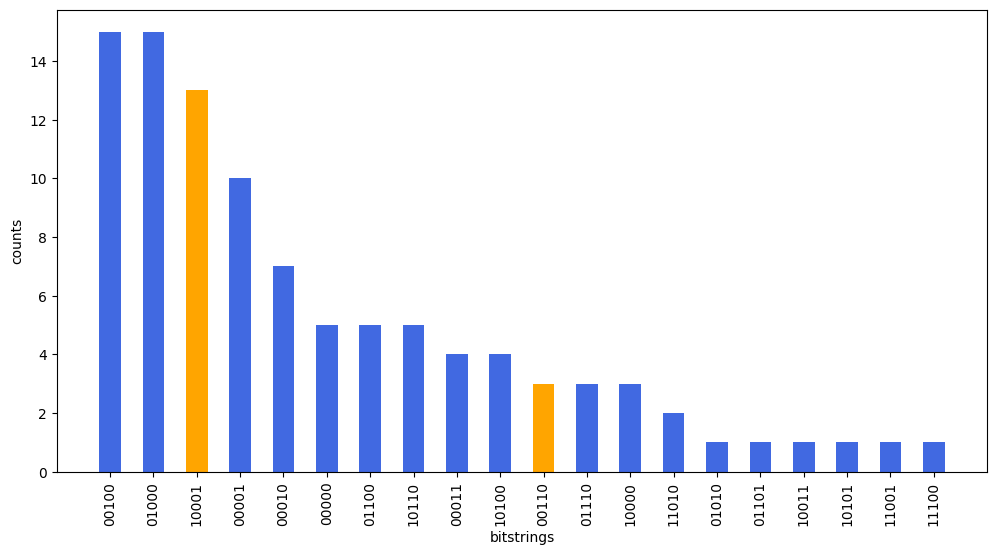

In [28]:
# Plot distribution
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)

However, using QAOA to solve the problem is not the best idea; it’s difficult to yield a >90% quality solution without going to high depths of the QAOA, implying that the growing closed-loop optimization can rapidly become expensive, with no guarantee of convergence.